<a href="https://colab.research.google.com/github/JayRolla/market-sales-/blob/main/market%20sales%20prediction%20final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install matplotlib

In [22]:
pip install ydata-profiling

In [23]:
import pandas as pd
import numpy as np
#import pandas profiling for quick summary of data
from ydata_profiling import ProfileReport
#libraries for visualizing the data
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
# Model selection and evaluation
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_squared_error

#Statistical analysis
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

# Machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Utility
import joblib
from joblib import dump, load

# Set up visualization settings for Jupyter Notebook (if using)
%matplotlib inline
sns.set_style("whitegrid")

In [9]:
train = pd.read_csv('https://raw.githubusercontent.com/JayRolla/market-sales-/main/train_market.csv')
test   = pd.read_csv('https://raw.githubusercontent.com/JayRolla/market-sales-/main/test_market.csv')

In [26]:
profile = ProfileReport(train, title='Pandas Profiling Report on training data', explorative=True)
profile.to_widgets()

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:524: UserWarning: Ipywidgets is not yet fully supported on Google Colab (https://github.com/googlecolab/colabtools/issues/60).As an alternative, you can use the HTML report. See the documentation for more information.
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

In [13]:
profile = ProfileReport(test, title='Pandas Profiling Report on test data', explorative=True)
profile.to_widgets()

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:524: UserWarning: Ipywidgets is not yet fully supported on Google Colab (https://github.com/googlecolab/colabtools/issues/60).As an alternative, you can use the HTML report. See the documentation for more information.
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

Item weight in both datasets contains missing values and there are a couple of NaN values in the outlet size


In [14]:
df1 = train.copy()
df2 = test.copy()

In [16]:
def impute_item_weight(df):
    """Impute missing Item_Weight based on the mean weight of the corresponding Item_Type."""
    return df.groupby('Item_Type')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))

def impute_outlet_size(df):
    """Impute missing Outlet_Size based on the mode size of the corresponding Outlet_Type."""
    return df.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

'''
Now, i apply these functions to THE training and test datasets (df1 and df2),
Since I AM applying the same transformations to both datasets,
this approach ensures consistency in how missing values are handled across your datasets. '''


df1['Item_Weight'] = impute_item_weight(df1)
df1['Outlet_Size'] = impute_outlet_size(df1)

df2['Item_Weight'] = impute_item_weight(df2)
df2['Outlet_Size'] = impute_outlet_size(df2)

In [17]:
# Check if there are any NaN values left in the 'Item_Weight' and 'Outlet_Size' columns of df1
print("Training Set (df1) Missing Values Check:")
print("Item_Weight missing values:", df1['Item_Weight'].isnull().sum())
print("Outlet_Size missing values:", df1['Outlet_Size'].isnull().sum())

# Check if there are any NaN values left in the 'Item_Weight' and 'Outlet_Size' columns of df2
print("\nTest Set (df2) Missing Values Check:")
print("Item_Weight missing values:", df2['Item_Weight'].isnull().sum())
print("Outlet_Size missing values:", df2['Outlet_Size'].isnull().sum())


Training Set (df1) Missing Values Check:
Item_Weight missing values: 0
Outlet_Size missing values: 0

Test Set (df2) Missing Values Check:
Item_Weight missing values: 0
Outlet_Size missing values: 0


In [18]:
def check_unique_values(df):
    """
    I wrote this function to iterate through a list of specified columns in a DataFrame (df)
    and print the unique values present in each column. This helps me to quickly identify
    discrepancies, such as inconsistent categorization or misspellings, before proceeding
    with data cleaning. It's particularly useful when I'm familiarizing myself with a new dataset
    or ensuring that my cleaning efforts have been successful.

    Parameters:
    - df (pd.DataFrame): The DataFrame on which I want to check the unique values.

    The function doesn't return anything; its primary purpose is to print information.
    """

    # I defined a list of columns that I'm interested in checking for unique values.
    columns_to_check = ['Item_Fat_Content', 'Item_Visibility', 'Item_Type',
                        'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
                        'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales']

    for column in columns_to_check:
        # Here, I check if the current column exists in the DataFrame.
        if column in df.columns:
            print(f"Unique values in '{column}':")
            # I sort the unique values for easier reading and potential issue spotting.
            print(sorted(df[column].unique()), "\n")
        else:
            # If a column isn't found, I'll make a note of it.
            print(f"Column '{column}' does not exist in this DataFrame.\n")

# Now, I'll apply this function to both my training and test datasets.
print("Training Dataset (df1):")
check_unique_values(df1)

print("\nTest Dataset (df2):")
check_unique_values(df2)


Training Dataset (df1):
Unique values in 'Item_Fat_Content':
['LF', 'Low Fat', 'Regular', 'low fat', 'reg'] 

Unique values in 'Item_Visibility':
[0.0, 0.003574698, 0.003589104, 0.003597678, 0.003599378, 0.003606726, 0.003612411, 0.005209791, 0.005230786, 0.005234153, 0.005235143, 0.005243282, 0.005264755, 0.005448005, 0.00547348, 0.005474515, 0.005485618, 0.005496816, 0.005505481, 0.005525913, 0.00552947, 0.005530516, 0.005539114, 0.005547386, 0.005557062, 0.005561538, 0.005561798, 0.005583951, 0.005611367, 0.005620213, 0.005638944, 0.005661669, 0.005677876, 0.005935001, 0.005949644, 0.005958918, 0.005962753, 0.005963881, 0.00597362, 0.005977465, 0.005978595, 0.00599072, 0.005997615, 0.006012413, 0.006061565, 0.006075007, 0.006087409, 0.006289291, 0.006295472, 0.006335942, 0.006351876, 0.00636189, 0.006665667, 0.006692529, 0.006708517, 0.006725388, 0.006727008, 0.006754117, 0.006759519, 0.00676387, 0.006765149, 0.006770252, 0.006775667, 0.007006883, 0.007038478, 0.00704098, 0.00704300

In [19]:
def standardize_fat_content(df):
    """
    I created this function to standardize the 'Item_Fat_Content' column values.
    It maps various representations of fat content ('LF', 'low fat', and 'reg')
    to a consistent format ('Low Fat' and 'Regular'). This helps ensure uniformity
    and reduces potential issues caused by categorical value discrepancies.

    Parameters:
    - df (pd.DataFrame): The DataFrame for which the 'Item_Fat_Content' values need to be standardized.

    Returns:
    - df (pd.DataFrame): The DataFrame with standardized 'Item_Fat_Content' values.
    """

    # I define a mapping from the observed categories to the standardized ones.
    fat_content_mapping = {
        'LF': 'Low Fat',
        'low fat': 'Low Fat',
        'reg': 'Regular'
    }

    # I use the 'replace' method to apply this mapping across the 'Item_Fat_Content' column.
    df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(fat_content_mapping)

    return df

# Now, I'll apply this function to both my training and test datasets.
df1 = standardize_fat_content(df1)
df2 = standardize_fat_content(df2)

# To verify the standardization worked as expected, I print the unique values again.
print("After standardization, unique values in 'Item_Fat_Content' for Training Dataset (df1):")
print(df1['Item_Fat_Content'].unique())

print("\nAfter standardization, unique values in 'Item_Fat_Content' for Test Dataset (df2):")
print(df2['Item_Fat_Content'].unique())


After standardization, unique values in 'Item_Fat_Content' for Training Dataset (df1):
['Low Fat' 'Regular']

After standardization, unique values in 'Item_Fat_Content' for Test Dataset (df2):
['Low Fat' 'Regular']


In [20]:
# Understanding basic statistical details of numerical features
print(df1[['Item_MRP', 'Item_Outlet_Sales']].describe())

#  To get a sense of the central tendency and dispersion of item prices and sales.


          Item_MRP  Item_Outlet_Sales
count  8523.000000        8523.000000
mean    140.992782        2181.288914
std      62.275067        1706.499616
min      31.290000          33.290000
25%      93.826500         834.247400
50%     143.012800        1794.331000
75%     185.643700        3101.296400
max     266.888400       13086.964800


In [28]:
# Visualizing the distribution of 'Item_MRP' and 'Item_Outlet_Sales'
df1[['Item_MRP', 'Item_Outlet_Sales']].hist(bins=50, figsize=(12, 5))
plt.show()

# Why: To check for skewness, understand the distribution, and identify outliers in these key columns.

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

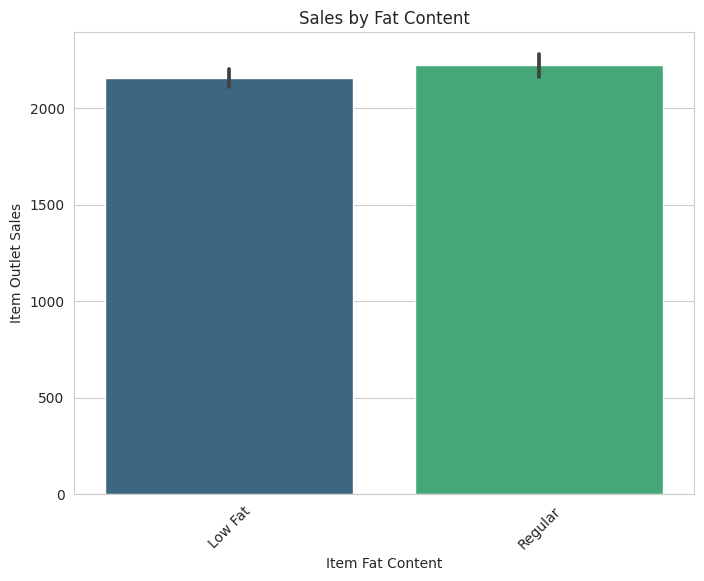

In [27]:
#Sales by Fat Content
plt.figure(figsize=(8, 6))
sns.barplot(x='Item_Fat_Content', y='Item_Outlet_Sales', data=df1, palette='viridis')
plt.title('Sales by Fat Content')
plt.ylabel('Item Outlet Sales')
plt.xlabel('Item Fat Content')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df1['Store_Age'] = 2034 - df1['Outlet_Establishment_Year']

# 3. Sales by Store Age
plt.figure(figsize=(10, 6))
sns.barplot(x='Store_Age', y='Item_Outlet_Sales', data=df1, palette='coolwarm')
plt.title('Sales by Store Age')
plt.ylabel('Item Outlet Sales')
plt.xlabel('Store Age')
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Store_Age', y='Outlet_Type', data=df1, palette='coolwarm')
plt.title('Sales by Store Age')
plt.ylabel('Item Outlet Sales')
plt.xlabel('Store Age')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 5. Sales by Outlet Type
plt.figure(figsize=(8, 6))
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=df1, palette='icefire')
plt.title('Sales by Outlet Type')
plt.ylabel('Item Outlet Sales')
plt.xlabel('Outlet Type')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# 2. Sales by Visibility
plt.figure(figsize=(20, 6))
sns.scatterplot(x='Item_Type', y='Item_Visibility', data=df1, color='blue', alpha=0.6)
plt.title('Item by Visibility')
plt.ylabel('Item Visibility')
plt.xlabel('Item Type')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.lmplot(x='Item_Visibility', y='Item_Outlet_Sales', hue='Item_Type', data=df1, palette='coolwarm', aspect=2, height=6)
plt.title('Visibility of Item and Its Sales with Trend Lines')
plt.ylabel('Item Outlet Sales')
plt.xlabel('Item Visibility')
plt.show()




In [ ]:
# 4. Sales by Item Type
plt.figure(figsize=(12, 8))
sns.barplot(x='Item_Type', y='Item_Outlet_Sales', data=df1, palette='magma')
plt.title('Sales by Item Type')
plt.ylabel('Item Outlet Sales')
plt.xlabel('Item Type')
plt.xticks(rotation=90)
plt.show()

In [ ]:
g = sns.FacetGrid(df1, col='Outlet_Type', hue='Item_Fat_Content', col_wrap=2, height=4, palette='coolwarm')
g = g.map(plt.scatter, 'Item_Visibility', 'Item_Outlet_Sales', edgecolor="w").add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Visibility vs. Sales by Outlet Type and Fat Content')
plt.show()


In [ ]:
g = sns.FacetGrid(df1, col="Outlet_Type", col_wrap=2, height=4, margin_titles=True)
g.map_dataframe(sns.scatterplot, x="Item_Type", y="Item_Visibility", hue="Item_Fat_Content")
g.set_axis_labels("Item Type", "Item Visibility")
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Highest selling item type for each store type
highest_sales_per_store = df1.loc[df1.groupby('Outlet_Type')['Item_Outlet_Sales'].idxmax()]

# Lowest selling item type for each store type
lowest_sales_per_store = df1.loc[df1.groupby('Outlet_Type')['Item_Outlet_Sales'].idxmin()]

# Highest visibility item type for each store type
highest_visibility_per_store = df1.loc[df1.groupby('Outlet_Type')['Item_Visibility'].idxmax()]

# Lowest visibility item type for each store type
lowest_visibility_per_store = df1.loc[df1.groupby('Outlet_Type')['Item_Visibility'].idxmin()]

# Displaying the results
print("Highest Selling Item Type for Each Store Type:")
print(highest_sales_per_store[['Outlet_Type', 'Item_Type', 'Item_Outlet_Sales']], '\n')

print("Lowest Selling Item Type for Each Store Type:")
print(lowest_sales_per_store[['Outlet_Type', 'Item_Type', 'Item_Outlet_Sales']], '\n')

print("Highest Visibility Item Type for Each Store Type:")
print(highest_visibility_per_store[['Outlet_Type', 'Item_Type', 'Item_Visibility']], '\n')

print("Lowest Visibility Item Type for Each Store Type:")
print(lowest_visibility_per_store[['Outlet_Type', 'Item_Type', 'Item_Visibility']])


In [ ]:
# Descriptive Statistics for Item_Outlet_Sales
sales_desc = df1['Item_Outlet_Sales'].describe()
print(sales_desc)

In [ ]:
# Select only numerical columns for correlation analysis
numerical_df = df1.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_df.corr()
print(correlation_matrix['Item_Outlet_Sales'])

In [ ]:
# Distribution Analysis of Item_Outlet_Sales
sns.histplot(df1['Item_Outlet_Sales'], kde=True)

# Interpretation:
# - A symmetric distribution suggests balanced sales.
# - Skewness indicates bias towards lower or higher sales.
# - KDE curve helps understand the shape of distribution.

In [ ]:
sns.boxplot(x=df1['Item_Outlet_Sales'])

# Interpretation:
# - Points beyond the whiskers in the boxplot indicate outliers.
# - Identifying outliers is crucial for understanding sales extremes and data quality.


In [ ]:
# Grouped Analysis by Outlet_Type
grouped_sales_outlet_type = df1.groupby('Outlet_Type')['Item_Outlet_Sales'].mean()
print(grouped_sales_outlet_type)

# Interpretation:
# This analysis provides average sales figures for each type of outlet, helping identify which outlet type performs best.

In [ ]:
# Assuming you have two types of outlets: 'Grocery Store' and 'Supermarket Type1'
group1 = df1[df1['Outlet_Type'] == 'Grocery Store']['Item_Outlet_Sales']
group2 = df1[df1['Outlet_Type'] == 'Supermarket Type1']['Item_Outlet_Sales']

# Perform T-Test
t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
print(f"T-Statistic: {t_stat}, P-value: {p_val}")

# Interpretation:
# - A low p-value (typically < 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.
# - A high p-value (> 0.05) suggests weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

In [ ]:
# Dynamically generating groups for ANOVA
outlet_types = df1['Outlet_Type'].unique()  # Extracts all unique outlet types from your DataFrame
groups = [df1[df1['Outlet_Type'] == outlet]['Item_Outlet_Sales'] for outlet in outlet_types]

# Perform ANOVA
f_stat, p_val = f_oneway(*groups)
print(f"F-Statistic: {f_stat}, P-value: {p_val}")

# Interpretation:
# - An F-Statistic value indicates the ratio of variance between the groups to the variance within the groups.
# - A low p-value (<0.05) suggests that there are significant differences in the average sales across different outlet types,
#   meaning at least one outlet type's average sales differ significantly from the others.

In [29]:
# Creating a contingency table of the frequencies of Outlet_Location_Type and Outlet_Size
contingency_table = pd.crosstab(df1['Outlet_Location_Type'], df1['Outlet_Size'])

# Performing the Chi-Square Test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Squared Value: {chi2}")
print(f"P-Value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

# Interpretation
if p_value < 0.05:
    print("There is a significant association between Outlet Location Type and Outlet Size.")
else:
    print("There is no significant association between Outlet Location Type and Outlet Size.")


''' Explanation:
Chi-Squared Value: This is the test statistic. A higher value indicates a greater discrepancy between observed and expected frequencies under the null hypothesis of independence.
P-Value: This indicates the probability of observing the data if the null hypothesis is true. A low p-value (typically < 0.05) suggests rejecting the null hypothesis, implying a significant association between the variables.
Degrees of Freedom: This is calculated based on the number of levels in each categorical variable. It's used in determining the critical value from the chi-square distribution.
Expected Frequencies: These are the frequencies expected in each category combination if there were no association between the variables.'''

Chi-Squared Value: 4806.778592709207
P-Value: 0.0
Degrees of Freedom: 4
Expected Frequencies:
[[ 261.13058782  782.55121436 1344.31819782]
 [ 304.54300129  912.64871524 1567.80828347]
 [ 366.32641089 1097.8000704  1885.87351871]]
There is a significant association between Outlet Location Type and Outlet Size.


" Explanation:\nChi-Squared Value: This is the test statistic. A higher value indicates a greater discrepancy between observed and expected frequencies under the null hypothesis of independence.\nP-Value: This indicates the probability of observing the data if the null hypothesis is true. A low p-value (typically < 0.05) suggests rejecting the null hypothesis, implying a significant association between the variables.\nDegrees of Freedom: This is calculated based on the number of levels in each categorical variable. It's used in determining the critical value from the chi-square distribution.\nExpected Frequencies: These are the frequencies expected in each category combination if there were no association between the variables."